# Coinbase User Onboarding Flow: Analysis of Current Process and Possible Areas for Improvement

In this report, we take a look at three data sets related to new Coinbase customers' onboarding process and see where users churn away from using our platform. We also want to know:
1. Where in the onboarding process are users currently churning from the onboarding flow?
2. What are the biggest reasons for users to churn?
3. Does this vary over time and for different user segments?

And based on these questions and their answers, we want to improve our current business model to reduce the **churn rate**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set the "mako" color palette as the default
sns.set_palette("mako")

# load in all the data set.
users_df = pd.read_csv('data/users.csv')
id_verification_df = pd.read_csv('data/id_verification.csv')
trades_df = pd.read_csv('data/trades.csv')

## Exploratory Data Analysis & Data-Cleaning
### **Important Note About Null/NA/NaN/NaT values of Time-related columns**
Usually, during this stage of EDA, **Null values** are usually dealt with via filling them in with some calculated values or they are dropped.\
However, since we are looking at customers' **churn behavior**, Null values in time-related columns are actually a *very important* data values in our analysis, as they show **where users stopped using our service**.

## Analysis of Churning behavior of Overall Onboarding Process
The **users.csv** file allows us to look at overall trend in churning behavior for all stages of onboarding process, allowing us to calculate important summary statistics such as average time spent at each verification process, churning rate at each stage, and correlation between key metrics.

To begin, we'll go ahead and describe the current data set we have for users. And we'll also convert columns to logical formats of data types.

In [2]:
print(f'Total Length of The File: {len(users_df)}') # print out total length of df
print(f'Number of Unique Users: {len(set(users_df["user_id"]))}') # print out number of unique users
print(f'Possible Countries: {set(users_df["country"])}') # print possible outcomes of country
print(f'Possible Platforms: {set(users_df["platform"])}') # print all of possible platforms used by users

# we will convert all of time-stamp columns to Pandas date_time format in UTC
columns_to_convert = ['signed_up_at', 'phone_verified_at', 'email_verified_at', 'id_verified_at']
users_df[columns_to_convert] = users_df[['signed_up_at', 'phone_verified_at', 'email_verified_at', 'id_verified_at']].apply(pd.to_datetime, errors='coerce', utc=True)

Total Length of The File: 11232
Number of Unique Users: 11232
Possible Countries: {'BR', 'CA', 'GB', 'US', nan}
Possible Platforms: {nan, 'web', 'android', 'ios'}


### Initial Observation:
Looking at above calculations and the data frame itself, we can deduce some important information.
1. There are no duplicates of users in this file (Total length equals unique number of users.)
2. For country and platform columns, some of the values are unidentifiable. This could give us a great insight on how no country lead to higher churn rates.
3. Skimming through the data set shows that the logical time ordering of onboarding/verification process is:
    1. First, Signing up (signed_up_at)
    2. Then, Email Verification (email_verified_at)
    3. Then, Phone Verification (phone_verified_at)
    4. Finally, ID Verification (id_verified_at)

Before we start charting, we'll create a new data frame that shows descriptive statistics for each stage of verification.
* We will go ahead and createa new dataframe called **stages_df** that shows descriptive statistics for each verification stages.
* We'll also compute time-difference between each stages in our original users_df and add them as new columns

In [3]:
total_users = len(users_df) # since we know no duplicate of users, this represents total number of users in this df

# now, reorder the column names based on user's onboarding process
users_df = users_df[['user_id', 'country', 'platform', 'signed_up_at', 'email_verified_at', 'phone_verified_at', 'id_verified_at']]
# we will pull out time-dependent columns (or columns of time-stamps)
stages = ['signed_up_at', 'email_verified_at', 'phone_verified_at', 'id_verified_at']
# also create a list of number of verified users at the each stage
verified = np.array([users_df[stage].notnull().sum() for stage in stages])
not_verified = total_users - verified # list of number of not verified users at each stage

# Calculate time taken for each stage (time difference in minutes)
signup_to_email = (users_df['email_verified_at'] - users_df['signed_up_at']).dt.total_seconds() / 60
email_to_phone  = (users_df['phone_verified_at'] - users_df['email_verified_at']).dt.total_seconds() / 60
phone_to_id = (users_df['id_verified_at'] - users_df['phone_verified_at']).dt.total_seconds() / 60

# we'll add these columns to the users_df
users_df.loc[:, 'signup_to_email'] = signup_to_email
users_df.loc[:, 'email_to_phone'] = email_to_phone
users_df.loc[:, 'phone_to_id'] = phone_to_id

# Create a new DataFrame called stages_df with descriptive statistics
stages_df = pd.DataFrame({
    'Stage': stages,
    'Total Users': total_users,
    'Verified Users': verified,
    'Denied Users': not_verified,
})

# we will add few more summary statistics such as avergae time difference, std. dev, and max, min minutes
time_diffs = [signup_to_email, email_to_phone, phone_to_id]
aggregations = {
    'Avg. Min. Spent': np.mean, 
    'Std. Dev. Minutes From Previous Stage': np.std,
    'Max Minutes From Previous Stage': np.max,
    'Min Minutes From Previous Stage': np.min,
}
for key, func in aggregations.items():
    stages_df[key] = [0] + [func(metric) for metric in time_diffs]

# finally, we'll add Churn Rate for each stage, where Churn_rate = denined_users at current stage / verified users at previous stage
stages_df['Churn Rate (%)'] = stages_df['Denied Users'] / stages_df['Verified Users'].shift(1) * 100
stages_df['Churn Rate (%)'] = stages_df['Churn Rate (%)'].fillna(27 / total_users * 100)  # Replace NaN for the first stage


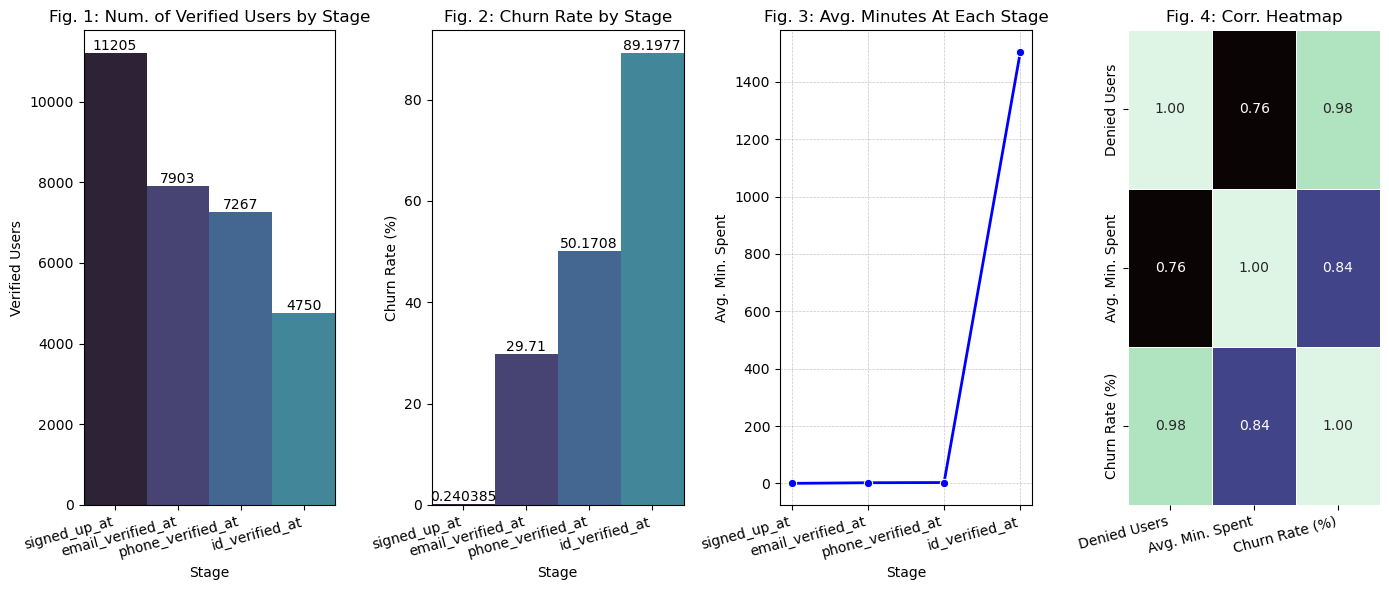

,Stage,Total Users,Verified Users,Denied Users,Avg. Min. Spent,Std. Dev. Minutes From Previous Stage,Max Minutes From Previous Stage,Min Minutes From Previous Stage,Churn Rate (%)
0,signed_up_at,11232,11205,27,0.000000,0.000000,0.000000,0.000000,0.240385
1,email_verified_at,11232,7903,3329,2.179941,0.683905,3.366190,1.000460,29.709951
2,phone_verified_at,11232,7267,3965,2.877904,0.708866,4.096541,1.617302,50.170821
3,id_verified_at,11232,4750,6482,1504.361781,946.195472,5942.558140,29.615175,89.197743


In [4]:
# create 2 by 3 subplots to put our plots in
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,6))

# horizontal barplot that shows number of verified users at each stage, showing where the sharpest drop off occurs
ax1 = sns.barplot(data = stages_df,y = 'Verified Users', x = 'Stage', ax = ax[0], hue = 'Stage', width = 1.0)
ax1.title.set_text("Fig. 1: Num. of Verified Users by Stage") # add a title
for i in ax1.containers: ax1.bar_label(i,) # for data value labels

# barplot that shows churn rate at each stage
ax2 = sns.barplot(data = stages_df,y = 'Churn Rate (%)', x = 'Stage', ax = ax[1], hue = 'Stage', width = 1.)
ax2.title.set_text("Fig. 2: Churn Rate by Stage") # add a title
for i in ax2.containers: ax2.bar_label(i,) # for data value labels

# Plot Time to Progress Across Stages in ax[0, 2]
sns.lineplot(data=stages_df,x='Stage',y='Avg. Min. Spent', marker='o', linewidth=2, color='blue', ax=ax[2])
ax[2].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax[2].title.set_text("Fig. 3: Avg. Minutes At Each Stage")

# heatmap of corrleation maxtrix
heat_map_data = stages_df[['Denied Users', 'Avg. Min. Spent', 'Churn Rate (%)']].corr() # Compute correlation matrix
sns.heatmap(heat_map_data, annot=True, cbar=False, cmap='mako', fmt=".2f", linewidths=0.5, ax = ax[3]) # Plot heatmap
ax[3].title.set_text("Fig. 4: Corr. Heatmap")

# Rotate x-axis labels for all subplots
for axes in ax.flat:  # Iterate over all subplots
    axes.set_xticklabels(axes.get_xticklabels(), rotation=15, ha='right')  # Rotate labels

plt.tight_layout() # for spacing between plots
plt.show()
stages_df.head()

### **Analysis of Churning Behaviors of Overall Onboarding Process**

#### Phase 1: From Sign-Up to Email Verification
- The number of users decreases from **11,232 (Signed Up)** to **7,903 (Email Verified)**, representing a churn rate of **29.7%**.
- Possible reasons for this drop-off:
  1. Users may lose interest during this stage.
  2. Emails may land in spam folders, leaving users unaware of their next steps.
  3. Checking an email for verification may be perceived as inconvenient.
- **Possible Recommendation:** The onboarding process should address email deliverability issues (e.g., avoiding spam) and provide reminders or incentives for users to complete this step.


#### Phase 2: From Email to Phone Verification
- Between **Email Verification (7,903)** and **Phone Verification (7,267)**, the churn rate is **8.0%**, significantly lower compared to earlier stages.
- Average time spent at this stage increases slightly to **2.88 minutes**, but this increase does not appear to cause significant drop-offs.
- **Possible Recommendation** The small churn here suggests that the process itself is not overly complex. However, repeated verification steps may start to fatigue users.


#### Phase 3: From Phone to ID Verification
- The largest drop-off occurs here, with verified users dropping from **7,267 (Phone Verified)** to **4,750 (ID Verified)**. This translates to a churn rate of **34.7%**.
- The **time spent at ID verification** skyrockets to an average of **1,504 minutes** (25+ hours), compared to just a few minutes in earlier stages. This delay is also accompanied by a sharp increase in **denied users (6,482)**.
- Strong correlations:
  1. **Denied Users & Churn Rate** (0.98): High denial rates directly increase churn.
  2. **Avg. Minutes & Churn Rate** (0.84): Longer delays strongly correlate with drop-offs.
- All of these pieces of information suggests that users at this stage have strong interest in finishing the onboarding process, as shown by time spent at ID verificaiton.
- However, they are encountered with complexity of ID verification and they start to get frustrated.
- Morever, there could be a possible bug or inefficiencies in our verification program, not allowing users to correctly and swiftly verify their ID.
- **Possible Recommendation** The complexity of ID verification, unclear instructions, and delays likely frustrate users. Simplifying the ID verification process, offering clear guidance, or providing live support could significantly reduce churn.

**The above analysis suggests that we should take a closer look at what is happening with user churning behavior at the ID Verification Stage.**

### Time-based Analysis of Valid Users For Each Stage Plus Trades
We will also go ahead and look at time-series plot of the number of users passing each stage of our onboarding process.\
Based on the months of year 2023, we will also plot number of trades created each month.

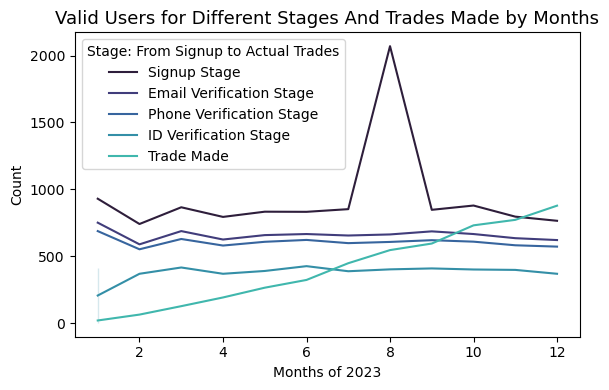

(None, None)

In [5]:
# first, data clean the trades_df:
trades_df['created_at'] = pd.to_datetime(trades_df['created_at'], utc=True, errors='coerce') # convert the created_at column to UTC time
# group the time by month and compute trade count for each month
trades_by_month = (trades_df[~trades_df['created_at'].isnull()]).groupby(pd.Grouper(key='created_at', freq='M')).size().reset_index(name='count')
# pull out only year 2023
trades_by_month = trades_by_month[trades_by_month['created_at'].dt.year==2023]
# create new month column for graphing purpose
trades_by_month['month'] = trades_by_month['created_at'].dt.month

# Prepare the data for each stage
valid_signup = users_df[~users_df['signed_up_at'].isnull()].groupby(pd.Grouper(key='signed_up_at', freq='M')).size().reset_index(name='count')
valid_signup['month'] = valid_signup['signed_up_at'].dt.month
# for email stage
valid_email = users_df[~users_df['email_verified_at'].isnull()].groupby(pd.Grouper(key='email_verified_at', freq='M')).size().reset_index(name='count')
valid_email['month'] = valid_email['email_verified_at'].dt.month
# for phone stage
valid_phone = users_df[~users_df['phone_verified_at'].isnull()].groupby(pd.Grouper(key='phone_verified_at', freq='M')).size().reset_index(name='count')
valid_phone['month'] = valid_phone['phone_verified_at'].dt.month
# for id verificaiont stage
valid_id = users_df[~users_df['id_verified_at'].isnull()].groupby(pd.Grouper(key='id_verified_at', freq='M')).size().reset_index(name='count')
valid_id['month'] = valid_id['id_verified_at'].dt.month

# Create a single plot
fig, ax = plt.subplots(figsize=(6, 4))
# Plot each stage as a separate line
sns.lineplot(data=valid_signup, x='month', y='count', ax=ax, label='Signup Stage')
sns.lineplot(data=valid_email, x='month', y='count', ax=ax, label='Email Verification Stage')
sns.lineplot(data=valid_phone, x='month', y='count', ax=ax, label='Phone Verification Stage')
sns.lineplot(data=valid_id, x='month', y='count', ax=ax, label='ID Verification Stage')
sns.lineplot(data=trades_by_month, x='month', y='count', ax = ax, label='Trade Made')
# Add labels, title, and legend
ax.set_title('Valid Users for Different Stages And Trades Made by Months', fontsize=13)
ax.set_xlabel('Months of 2023'), ax.set_ylabel('Count')
ax.legend(title='Stage: From Signup to Actual Trades')
# Show the plot
plt.tight_layout(), plt.show()

### **Analysis of "Valid Users by Month for Different Stages and Trades Made" (2023)**

This graph incorporates the count of valid users completing each stage of the onboarding process and the number of trades made across different months in 2023.
#### General Observations
- **Spike in Signups Around August (Month 8):**
  - The signup stage exhibits a significant spike in August, followed by a sharp decline.
  - This spike is not mirrored as strongly in later stages (Email, Phone, or ID Verification), indicating that most users who signed up in August churned early in the onboarding process.

- **Gradual Increase in Trades:**
  - The number of trades steadily increases throughout the year, eventually surpassing the ID verification count around August and continuing its upward trend into the later months.
  - This suggests that users who complete onboarding eventually engage with the platform and trade actively, regardless of onboarding fluctuations.

- **Consistency in Other Stages:**
  - Counts for email, phone, and ID verification remain relatively steady throughout the year, with a slight upward trend in the first half and a gradual decline in the later months.
  - The steady flow into these stages contrasts with the variability in signups and trades.

- **Drop-off Between Stages:**
  - The number of users completing ID verification remains significantly lower than earlier stages, reinforcing the observation that this stage is a key bottleneck.
  - The gap between ID verification and trades highlights that users who complete onboarding are more likely to trade consistently.

---

#### Plausible Historical Context Behind Observed Trends (2023)

##### Spike in Signups (August)
- **Crypto Market Recovery:** After a downturn in 2022, market conditions improved in mid-2023, leading to increased retail interest in trading platforms like Coinbase.
- **Regulatory Announcements:** In August 2023, the SEC clarified rules around cryptocurrency trading platforms, increasing public awareness and interest in regulated platforms.

##### Gradual Increase in Trades
- **Delayed Engagement:** The steady rise in trades suggests that users who complete onboarding may take time to become active traders, potentially due to market research or confidence building.
- **Market Momentum:** Bullish trends in cryptocurrency markets during late 2023 may have motivated more trading activity among onboarded users.

#### Implications of Steady Verification Counts and Rising Trades
- The consistency in email, phone, and ID verification counts indicates that users who commit to these stages have stable onboarding completion rates.
- The gap between ID verification and trades demonstrates that successful onboarding directly correlates with active platform usage.
  - Users who overcome onboarding friction are likely to trade consistently.

---

### **Recommendations**
1. **Investigate August Spike:** Analyze the drivers of the signup spike in August to identify successful acquisition strategies. Determine why these users failed to proceed to later stages.

2. **Streamline Later Stages:** Focus on reducing churn during the email, phone, and ID verification stages, particularly for users acquired during high-signup months.

3. **Reinforce Trade Engagement:** Design targeted campaigns for users who complete onboarding but delay trading, encouraging earlier platform engagement.

4. **Leverage Promotions:** Consider campaigns that encourage users who signed up in August but failed to complete onboarding to re-engage and finish the process.

## Closer Look At ID Verification Stage
Again, this stage of onboarding process showed highest number of denied users, maximum churning rate, and most time spent out of any stages.\
This suggests that there might be a major flaw of ID verification system in Coinbase or the process is just too complex for many users.

In [6]:
# for this section of analysis, we will need id_verification_df
id_verification_df['created_at'] = pd.to_datetime(id_verification_df['created_at'], utc = True) # convert created_at column to Pands datetime in UTC

# we want ot take a look at proportin of failure reasons alte,r so we will replce Nan with a string "None"
id_verification_df['failure_reason'] = id_verification_df['failure_reason'].fillna('None')

# we'll create a merged df of users_df and id_verification_df based on unique user_id
merged_df = pd.merge(users_df, id_verification_df, on = 'user_id')

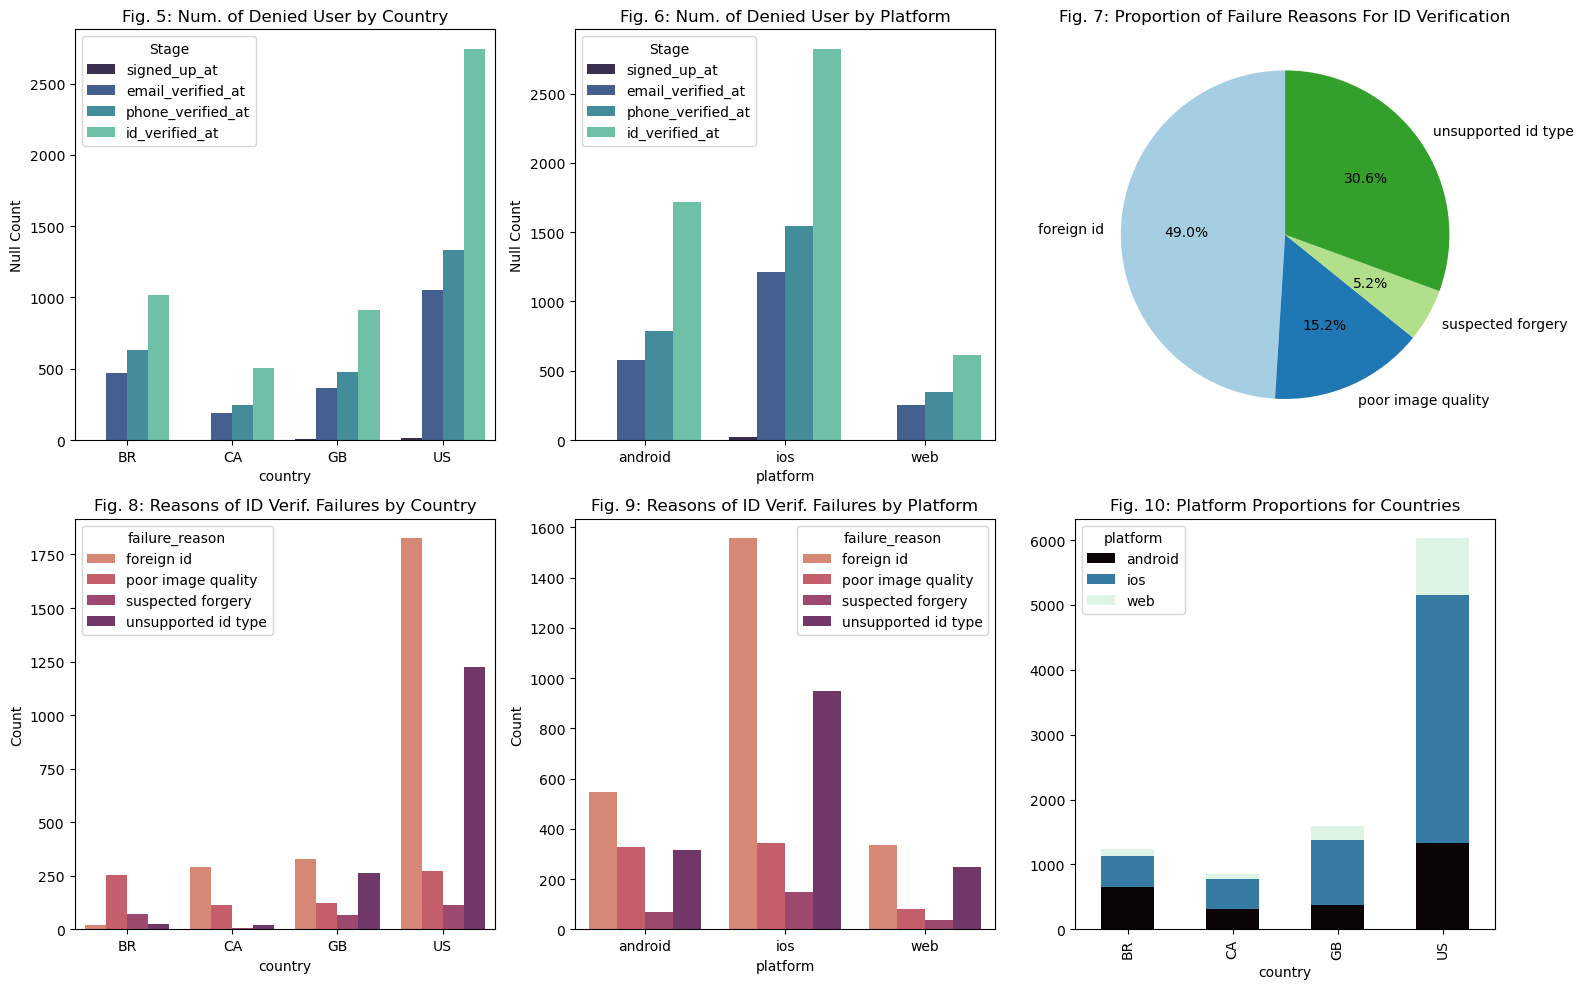

In [7]:
# create 2 by 3 subplots to put our plots in
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,10))

# we will plot number of null values in each stage w.r.t. user Country
# Create a DataFrame with null value counts for each stage by country
nulls_by_country = users_df.groupby('country')[stages].apply(lambda x: x.isnull().sum()).reset_index() # remember to reset the index so all the labels become columns
nulls_by_country = nulls_by_country.melt(id_vars='country', var_name='Stage', value_name='Null Count') # Transformthe nulls_by_country Df to a long format, which is required for sns
sns.barplot(data=nulls_by_country, x='country', y='Null Count', hue='Stage', palette='mako', ax = ax[0,0])
ax[0,0].title.set_text("Fig. 5: Num. of Denied User by Country")

# we will plot number of null values in each stage w.r.t. user platform
# Create a DataFrame with null value counts for each stage by platform
nulls_by_platform = users_df.groupby('platform')[stages].apply(lambda x: x.isnull().sum()).reset_index()
nulls_by_platform = nulls_by_platform.melt(id_vars='platform', var_name='Stage', value_name='Null Count')
sns.barplot(data=nulls_by_platform, x='platform', y='Null Count', hue='Stage', palette='mako', ax = ax[0,1])
ax[0,1].title.set_text("Fig. 6: Num. of Denied User by Platform")

# create a pie chart of failure_reason distribution
only_failures = id_verification_df[id_verification_df['status'] == 'failed'] # let's look at only failed attemps. create a new df
only_failures = only_failures.groupby('failure_reason').size().reset_index(name = "Count") # then group it by failure_reason and show the count for each fialure reason
ax[0,2].pie(only_failures['Count'],labels=only_failures['failure_reason'],autopct='%1.1f%%',startangle=90,colors=plt.cm.Paired.colors) # create a pie chart
ax[0,2].title.set_text("Fig. 7: Proportion of Failure Reasons For ID Verification")

# we also want to plot proportion of failure reasons for each country
failures_by_country = merged_df[merged_df['status']=='failed'].groupby(['country', 'failure_reason']).size().reset_index(name = "Count") # group merged df by country and failure_reason for failed attempts
sns.barplot(data = failures_by_country, x = 'country', y = 'Count', palette='flare', hue = 'failure_reason', ax = ax[1,0]) # create a grouped bar chart
ax[1,0].title.set_text("Fig. 8: Reasons of ID Verif. Failures by Country")

# we also want to plot proportion of failure reasons for each platform
failures_by_plat = merged_df[merged_df['status']=='failed'].groupby(['platform', 'failure_reason']).size().reset_index(name = "Count") # group merged df by country and failure_reason for failed attempts
sns.barplot(data = failures_by_plat, x = 'platform', y = 'Count', palette='flare', hue = 'failure_reason', ax = ax[1,1]) # create a grouped bar chart
ax[1,1].title.set_text("Fig. 9: Reasons of ID Verif. Failures by Platform")

# plot distribution of platforms for each country
country_plat_dist = users_df.groupby(['country', 'platform']).size().reset_index(name = "Count") # group merged df by country and platform for failed attempts
#sns.barplot(data=country_plat_dist, x='country', y='Count', hue='platform',palette='mako',ax=ax[1,2])
# Pivot the data for a stacked bar chart
stacked_data = country_plat_dist.pivot(index='country', columns='platform', values='Count').fillna(0)
# Plot the stacked bar chart
stacked_data.plot(kind='bar', stacked=True, colormap='mako', ax = ax[1,2])
ax[1,2].title.set_text("Fig. 10: Platform Proportions for Countries")

plt.tight_layout()
plt.show()


### **Analysis of Major Churning Point: ID Verification**

#### Observation 1: Onboarding Process Failures Disproportionately Impact US Users
- Figure 5 clearly shows that users logging in from the US experience the highest number of failures across **ALL verification stages**.
  - Note: this data represents absolute counts, not failure rates, so we cannot definitively say these failures are higher compared to other countries in proportion to their user base.
- Figure 6 supports this observation, as the US has a much higher proportion of *iPhone (iOS)* users, and **iOS users tend to encounter significantly more failures during the onboarding process compared to Android or web users**
  - On a side note, **web users show the lowest failure counts** across all verification stages, suggesting that larger screens and better input methods may reduce user errors.
- Figure 10 highlights that iOS users dominate the US platform distribution, which further correlates with the higher failure counts observed in the US.

Based on these findings, it is critical to investigate why US users, particularly iOS users, are facing higher failure rates during the ID verification stage.

#### Observation 2: US Users Struggle With ID Verification Due to Two Key Issues: Foreign ID and Unsupported ID Type
- Figure 8 clearly shows that US users experience extremely high failure rates for two main reasons:
  - **Foreign ID**: Nearly half of all ID verification failures for US users are attributed to this issue.
  - **Unsupported ID Type**: This is the second-most common failure reason, contributing significantly to user frustration and churn.
- Figure 9 reinforces this observation, as **iOS users** are disproportionately affected by **foreign ID** and **unsupported ID type** issues compared to Android or web users.

This highlights that US users are not only failing more frequently but are failing due to reasons that are potentially solvable with clearer communication or improved pre-validation systems.

##### Possible Reasons for High ID Verification Failures Among US Users

- *Foreign Nationals and Legal Immigrants*: Dual citizens, foreign nationals, or green card holders may submit foreign IDs that aren't supported by the system.  

- *Inconsistent ID Standards*: The US has no unified national ID system, leading to mismatches with state-specific formats or unsupported IDs.

- *High Usage of Fake IDs*: The US has a prevalent black market for fake IDs, commonly failing automated verification.

- *User Errors During Submission*: Poor image quality, incomplete submissions, or incorrect uploads often lead to failures.

- *Lack of Knowledge About Requirements*: Users might submit unsupported IDs (e.g., student IDs, foreign documents) due to misunderstanding requirements.

- *Cultural and Demographic Factors*: The US's diverse and mobile population, including international students and temporary workers, might lack access to required documents.

- *Systemic Issues in Verification Processes*: The system may struggle with diverse ID formats or biases, inadvertently rejecting valid IDs.

---

#### **Recommendations**
1. **Improve Guidance on Accepted IDs:** Provide a detailed list of supported document types with visual examples (e.g., US driver’s licenses, passports) during the onboarding process.

2. **Enhance Our Verification Technology:** Use AI/ML to handle diverse ID formats and flag potential errors proactively for user correction, if not already in use.

3. **Address Privacy Concerns:** Reassure users about data security and privacy during the ID submission process to encourage proper submissions.

4. **Specific Support for US Users:** Tailor messaging and FAQs for US-specific challenges, such as handling foreign IDs and fake IDs.

5. **Closer Look At our iOS Verification System** We can't ignore the possibly inherent bug in our iOS version of our mobile app. Taking a closer look at how we can improve verification system in iOS would be recommended.

